## Data Import Required Libraries

### Import Required Libraries

In [1]:
import pyspark.sql.functions as F
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer
from pyspark.ml.stat import Correlation
from pyspark.ml import Pipeline
from pyspark.sql.functions import *
from pyspark.sql.functions import col, avg, count, corr, month, year, to_timestamp
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql.window import Window
from pyspark.sql.types import StructType, StructField, TimestampType, StringType, DoubleType, IntegerType

### Define Schema and Import Data From Dataset

In [2]:
%%capture --no-stderr

# Create a Spark session
spark = SparkSession.builder.appName("FraudDetection").getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

# Define the schema
custom_schema = StructType([
    StructField("Timestamp", StringType(), nullable=True),
    StructField("FromBank", IntegerType(), nullable=True),
    StructField("FromAccount", StringType(), nullable=True),
    StructField("ToBank", IntegerType(), nullable=True),
    StructField("ToAccount", StringType(), nullable=True),
    StructField("AmountReceived", DoubleType(), nullable=True),
    StructField("ReceivingCurrency", StringType(), nullable=True),
    StructField("AmountPaid", DoubleType(), nullable=True),
    StructField("PaymentCurrency", StringType(), nullable=True),
    StructField("PaymentFormat", StringType(), nullable=True),
    StructField("IsLaundering", IntegerType(), nullable=True)
])

# Load the CSV file into a DataFrame with the specified schema
file_path = "HI-Small_Trans.csv"
df = spark.read.csv(file_path, header=True, schema=custom_schema)

# Register the DataFrame as a temporary SQL table
df.createOrReplaceTempView("transactions")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/10 02:27:11 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### Convert string data in 'Timestamp' column to timestamp datatype

In [3]:
from pyspark.sql.functions import to_timestamp

# Assuming "timestamp_str" is the column containing the timestamp string
df = df.withColumn("Timestamp", to_timestamp("Timestamp", "yyyy/MM/dd HH:mm"))

# Show the DataFrame schema with the new timestamp column
df.printSchema()

root
 |-- Timestamp: timestamp (nullable = true)
 |-- FromBank: integer (nullable = true)
 |-- FromAccount: string (nullable = true)
 |-- ToBank: integer (nullable = true)
 |-- ToAccount: string (nullable = true)
 |-- AmountReceived: double (nullable = true)
 |-- ReceivingCurrency: string (nullable = true)
 |-- AmountPaid: double (nullable = true)
 |-- PaymentCurrency: string (nullable = true)
 |-- PaymentFormat: string (nullable = true)
 |-- IsLaundering: integer (nullable = true)



### Standardize AmountReceived and AmountPaid Columns

In [4]:
import pandas as pd

# Define the exchange rates data
exchange_rates_data = [
    {"Currency": "Yen", "ExchangeRateToUSD": 0.0069},
    {"Currency": "UK Pound", "ExchangeRateToUSD": 1.234},
    {"Currency": "Australian Dollar", "ExchangeRateToUSD": 0.704},
    {"Currency": "Saudi Riyal", "ExchangeRateToUSD": 0.267},
    {"Currency": "Mexican Peso", "ExchangeRateToUSD": 0.050},
    {"Currency": "Shekel", "ExchangeRateToUSD": 0.300},
    {"Currency": "Yuan", "ExchangeRateToUSD": 0.147},
    {"Currency": "Canadian Dollar", "ExchangeRateToUSD": 0.754},
    {"Currency": "Euro", "ExchangeRateToUSD": 1.045},
    {"Currency": "Rupee", "ExchangeRateToUSD": 0.012},
    {"Currency": "Swiss Franc", "ExchangeRateToUSD": 1.028},
    {"Currency": "US Dollar", "ExchangeRateToUSD": 1.0},
    {"Currency": "Brazil Real", "ExchangeRateToUSD": 0.191},
    {"Currency": "Bitcoin", "ExchangeRateToUSD": 16386},
    {"Currency": "Ruble", "ExchangeRateToUSD": 0.013},
]

# Create the exchange_rates_df DataFrame in Pandas
exchange_rates_df = pd.DataFrame(exchange_rates_data)


In [5]:
from pyspark.sql.functions import col

exchange_rates_df = spark.createDataFrame(exchange_rates_df)

# Assuming df is your original DataFrame
# Assuming exchange_rates_df is another DataFrame with columns Currency, ExchangeRateToUSD

# Join the original DataFrame with exchange rates DataFrame for ReceivingCurrency
df_with_receiving_rate = df.join(
    exchange_rates_df.withColumnRenamed("Currency", "RecCurrency") \
                    .withColumnRenamed("ExchangeRateToUSD", "ReceivingExchangeRate"),
    col("RecCurrency") == col("ReceivingCurrency")  # Assuming the original column name in df is ReceivingCurrencyOriginal
)

# Join the resulting DataFrame with exchange rates DataFrame for PaymentCurrency
df_with_rates = df_with_receiving_rate.join(
    exchange_rates_df.withColumnRenamed("Currency", "PayCurrency") \
                    .withColumnRenamed("ExchangeRateToUSD", "PaymentExchangeRate"),
    col("PayCurrency") == col("PaymentCurrency")  # Assuming the original column name in df is PaymentCurrencyOriginal
)

# Convert AmountReceived and AmountPaid to USD based on exchange rates
currency_converted_df = df_with_rates.withColumn("AmountReceivedUSD", col("AmountReceived") * col("ReceivingExchangeRate"))
currency_converted_df = currency_converted_df.withColumn("AmountPaidUSD", col("AmountPaid") * col("PaymentExchangeRate"))

# Select the relevant columns
currency_converted_df = currency_converted_df.select("Timestamp", "FromBank", "FromAccount", "ToBank", "ToAccount",
                                                     "AmountReceived", "ReceivingCurrency", "AmountReceivedUSD",
                                                     "AmountPaid", "PaymentCurrency", "AmountPaidUSD",
                                                     "PaymentFormat", "IsLaundering")

# Show the resulting DataFrame Schema
df = currency_converted_df

df.printSchema()

/opt/conda/envs/csgy-6513d-fall2023/lib/python3.9/site-packages/pyspark/sql/pandas/conversion.py:485: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if should_localize and is_datetime64tz_dtype(s.dtype) and s.dt.tz is not None:


root
 |-- Timestamp: timestamp (nullable = true)
 |-- FromBank: integer (nullable = true)
 |-- FromAccount: string (nullable = true)
 |-- ToBank: integer (nullable = true)
 |-- ToAccount: string (nullable = true)
 |-- AmountReceived: double (nullable = true)
 |-- ReceivingCurrency: string (nullable = true)
 |-- AmountReceivedUSD: double (nullable = true)
 |-- AmountPaid: double (nullable = true)
 |-- PaymentCurrency: string (nullable = true)
 |-- AmountPaidUSD: double (nullable = true)
 |-- PaymentFormat: string (nullable = true)
 |-- IsLaundering: integer (nullable = true)



## 3. Transaction Network Analysis

### 3.1 Which are the accounts with suspicious transaction spikes in the entire dataset?

+---------+-------------------+-----------------+---------+
|ToAccount|          Timestamp|previous_accounts|hop_count|
+---------+-------------------+-----------------+---------+
|800051110|2022-09-07 20:02:00|      [811B6E170]|        1|
|800051110|2022-09-08 06:18:00|      [811A4DBD0]|        1|
|800051110|2022-09-10 15:19:00|      [8000E1590]|        1|
|800054B70|2022-09-03 08:47:00|      [8001FE5D0]|        1|
|800054B70|2022-09-08 02:28:00|      [80012E0B0]|        1|
+---------+-------------------+-----------------+---------+
only showing top 5 rows



/opt/conda/envs/csgy-6513d-fall2023/lib/python3.9/site-packages/pyspark/sql/pandas/types.py:563: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if not is_datetime64tz_dtype(pser.dtype):
/opt/conda/envs/csgy-6513d-fall2023/lib/python3.9/site-packages/pyspark/sql/pandas/types.py:379: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if is_datetime64tz_dtype(s.dtype):


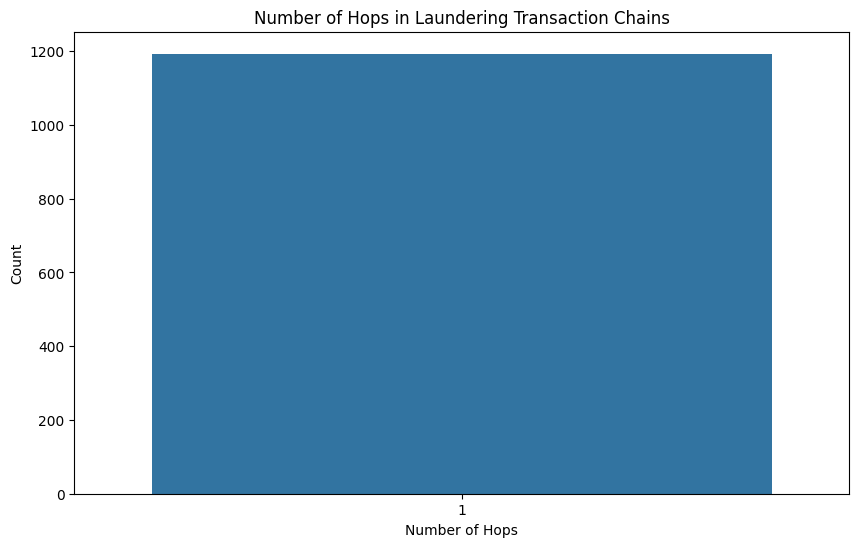

In [6]:
from pyspark.sql import Window
from pyspark.sql.functions import lag, col, collect_list, size
import seaborn as sns
import matplotlib.pyplot as plt

# Define the window specification
chain_window = Window.partitionBy("ToAccount").orderBy("Timestamp")

# Calculate previous accounts and count the number of hops
chains_df = df.filter("IsLaundering = 1") \
              .withColumn("prev_account", lag("FromAccount", 1).over(chain_window)) \
              .filter("prev_account is not null") \
              .groupBy("ToAccount", "Timestamp") \
              .agg(collect_list("prev_account").alias("previous_accounts"))

# Add a new column for hop count
chains_df = chains_df.withColumn("hop_count", size("previous_accounts"))

# Sort the DataFrame by hop_count in descending order
chains_df = chains_df.orderBy("hop_count", ascending=False)

# Show the top 5 records
chains_df.show(5)

# Visualize using Seaborn and Matplotlib
plt.figure(figsize=(10, 6))
sns.countplot(data=chains_df.toPandas(), x="hop_count")
plt.title('Number of Hops in Laundering Transaction Chains')
plt.xlabel('Number of Hops')
plt.ylabel('Count')
plt.show()



## 4. Model Building

### 4.1 Up-sample minority class

In [7]:
laundering_df = df.filter("IsLaundering = 1")

# Create a 40% sample of the laundering_df DataFrame
sampled_laundering_df = laundering_df.sample(False, 0.4, seed=42)

# Union the original DataFrame with the sampled laundering DataFrame
balanced_df = df.union(sampled_laundering_df)

In [8]:

# Show the first few rows of the resulting DataFrame
#balanced_df.count()

### 4.2 Down-sample majority class

In [9]:
# Create a negative sample (non-laundering transactions) with a 10% sample rate
neg_df = df.filter("IsLaundering = 0").sample(False, 0.1, seed=42)

# Union the original laundering transactions with the negative sample
balanced_df = laundering_df.union(neg_df)


In [10]:
# Show the first few rows of the resulting DataFrame
#balanced_df.count()

### Split Data into Training and Testing Sets


In [30]:
(train_df, test_df) = balanced_df.randomSplit([0.75, 0.25], seed=42)

In [15]:
#train_df.count()

In [31]:
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import LogisticRegression

# List of categorical columns
categorical_columns = ["ReceivingCurrency", "PaymentCurrency", "PaymentFormat"]

# StringIndexer stages for handling categorical columns
indexers_train = [StringIndexer(inputCol=col, outputCol=f"{col}_index").fit(train_df) for col in categorical_columns]
indexers_test = [StringIndexer(inputCol=col, outputCol=f"{col}_index").fit(test_df) for col in categorical_columns]

In [32]:
# Feature columns including the newly created indices
exclude_columns = ["Timestamp", "FromAccount", "ToAccount"]
all_columns = balanced_df.columns
feature_columns = [f"{col}_index" if col in categorical_columns else col for col in all_columns if col not in exclude_columns]

# Include IsLaundering in the feature columns
feature_columns.append("IsLaundering")

# Apply StringIndexer transformations for training data
for indexer in indexers_train:
    train_df = indexer.transform(train_df)

# Feature vector assembly for training data
vector_assembler_train = VectorAssembler(inputCols=feature_columns, outputCol="features")
assembler_train_df = vector_assembler_train.transform(train_df)

# Drop original categorical columns and IsLaundering for training data
assembler_train_df = assembler_train_df.drop(*categorical_columns)



In [33]:
# Apply StringIndexer transformations for test data
for indexer in indexers_test:
    test_df = indexer.transform(test_df)

# Feature vector assembly for test data
vector_assembler_test = VectorAssembler(inputCols=feature_columns, outputCol="features")
assembler_test_df = vector_assembler_test.transform(test_df)

# Drop original categorical columns and IsLaundering for test data
assembler_test_df = assembler_test_df.drop(*categorical_columns)


In [19]:
# Logistic Regression model
lr = LogisticRegression(featuresCol="features", labelCol="IsLaundering")
model = lr.fit(assembler_train_df)


In [20]:
# Specify the path where you want to save the model
model_path = "logistic_regression_model"

# Save the model
model.save(model_path)

In [22]:
from pyspark.ml.classification import LogisticRegressionModel

# Load the saved model
loaded_model = LogisticRegressionModel.load(model_path)

In [24]:
assembler_train_df.columns

['Timestamp',
 'FromBank',
 'FromAccount',
 'ToBank',
 'ToAccount',
 'AmountReceived',
 'AmountReceivedUSD',
 'AmountPaid',
 'AmountPaidUSD',
 'IsLaundering',
 'ReceivingCurrency_index',
 'PaymentCurrency_index',
 'PaymentFormat_index',
 'features']

In [34]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Assuming you have a labeled test dataset with a column named "label"
# Replace 'test_df' with your actual test dataset
test_df = assembler_test_df

# Make predictions on the test set using the loaded model
predictions = loaded_model.transform(test_df)

# Create a BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="IsLaundering", metricName="areaUnderROC")

# Evaluate the model and get the AUC score
auc_score = evaluator.evaluate(predictions)
print(f"Area Under ROC (AUC): {auc_score}")


Area Under ROC (AUC): 0.9999881043571729


In [35]:
# Penalize algorithms based on sensitivity

from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Assuming you have a labeled test dataset with a column named "label"
# Replace 'test_df' with your actual test dataset
test_df = assembler_test_df

# Make predictions on the test set using the loaded model
predictions = loaded_model.transform(test_df)

# Create a MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="IsLaundering", metricName="f1")

# Evaluate the model and get the F1 score
f1_score = evaluator.evaluate(predictions)
print(f"F1 Score: {f1_score}")


F1 Score: 1.0


In [38]:
from pyspark.ml import Pipeline  
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(labelCol="IsLaundering", featuresCol="features", maxIter=5)
pipeline = Pipeline(stages=[gbt])  

gbt_model = pipeline.fit(assembler_train_df)

In [45]:
gbt_model.save("gbt_model_5_iter")

#### The GBTClassifier in PySpark does not have a direct parameter for the number of epochs like some other machine learning libraries. Instead, it uses the maxIter parameter to control the maximum number of iterations (trees) in the ensemble. If you want to simulate the concept of epochs in the context of a gradient-boosted tree model, you can set the maxIter parameter to the desired number of "epochs." Each iteration (epoch) adds a new tree to the ensemble.



In [50]:
from pyspark.ml import PipelineModel

# Load the GBT model
loaded_gbt_model = PipelineModel.load("gbt_model_5_iter")

# Now, you can use the loaded_gbt_model for predictions on new data
gbt_predictions = loaded_gbt_model.transform(assembler_test_df)

# Show the predictions
gbt_predictions.select("prediction", "IsLaundering").show()

+----------+------------+
|prediction|IsLaundering|
+----------+------------+
|       1.0|           1|
|       1.0|           1|
|       1.0|           1|
|       1.0|           1|
|       1.0|           1|
|       1.0|           1|
|       1.0|           1|
|       1.0|           1|
|       1.0|           1|
|       1.0|           1|
|       1.0|           1|
|       1.0|           1|
|       1.0|           1|
|       1.0|           1|
|       1.0|           1|
|       1.0|           1|
|       1.0|           1|
|       1.0|           1|
|       1.0|           1|
|       1.0|           1|
+----------+------------+
only showing top 20 rows



In [51]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# Assuming 'predictions' is the DataFrame containing the predictions from your GBT model
# Replace "prediction" with the actual column name where your model outputs the predictions
# Replace "IsLaundering" with the actual column name where your labels are

# ROC AUC
binary_evaluator = BinaryClassificationEvaluator(labelCol="IsLaundering", metricName="areaUnderROC")
roc_auc = binary_evaluator.evaluate(gbt_predictions)
print(f"ROC AUC: {roc_auc}")

# F1 Score
multiclass_evaluator = MulticlassClassificationEvaluator(labelCol="IsLaundering", metricName="f1")
f1_score = multiclass_evaluator.evaluate(gbt_predictions)
print(f"F1 Score: {f1_score}")



ROC AUC: 1.0


F1 Score: 1.0
